# Capstone Project: Deep RL Trading Agent

## Introduction

Here is the structure of the project Python source code: 

- `task.py`: the environment definition in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `buyandholdagent.py`: Benchmark agent.
    - `deeprlagent.py`: the deep rl trading agent.
- `market.py`: This file contains the interface to the stock market data.
- `data/`: stock prices.
- `resources/`: additional files.

## Data Loading
The data set is constructed from the raw data files.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd

# loading the stock prices
# all trade data is coming from XETRA

df_usinterest =  pd.read_csv('data/FRB_H15.csv', header=5, names=['day','US_rate'], skiprows=0, parse_dates=[0],\
                          infer_datetime_format=True)

df_sp500_prices = pd.read_csv('data/Investing_622391_historic_data.csv', header=0,\
                           names=['day','closing', 'opening', 'high', 'low', 'vol', 'change'],\
                           skiprows=0, parse_dates=[0], infer_datetime_format=True, decimal=',')

df_eurostoxx600_prices = pd.read_csv('data/Investing_DBX1A7_historic_data.csv', header=0,\
                           names=['day','closing', 'opening', 'high', 'low', 'vol', 'change'],\
                           skiprows=0, parse_dates=[0], infer_datetime_format=True, decimal=',')

df_msciworld_prices = pd.read_csv('data/Investing_ETF110_historic_data.csv', header=0,\
                           names=['day','closing', 'opening', 'high', 'low', 'vol', 'change'],\
                           skiprows=0, parse_dates=[0], infer_datetime_format=True, decimal=',')

# convert vol column to float dtype
#1. remove K, M, -
#2. replace , with .
#3. parse as float
#4. multiply by 1000, 1000000
def vol2float(x):
    if (x.find('-')!=-1):
        return float(0.0)
    
    if (x.find('K')!=-1):
        return float(x.replace('K','').replace(',','.'))*1000.00
    
    if (x.find('M')!=-1):
        return float(x.replace('M','').replace(',','.'))*1000000.00
    
    return float('nan')

df_sp500_prices['SP500_volno'] = df_sp500_prices['vol'].apply(vol2float)
df_eurostoxx600_prices['ESTOXX_volno'] = df_eurostoxx600_prices['vol'].apply(vol2float)
df_msciworld_prices['MSCI_volno'] = df_msciworld_prices['vol'].apply(vol2float)

# remove records without closing price
df_sp500_prices = df_sp500_prices.dropna(subset=['closing'])
df_eurostoxx600_prices = df_eurostoxx600_prices.dropna(subset=['closing'])
df_msciworld_prices = df_msciworld_prices.dropna(subset=['closing'])

# rename price and volumn columns
df_sp500_prices=df_sp500_prices.rename(columns={"closing": "SP500_price"})
df_eurostoxx600_prices = df_eurostoxx600_prices.rename(columns={"closing": "ESTOXX_price"})
df_msciworld_prices = df_msciworld_prices.rename(columns={"closing": "MSCI_price"})


# create calendar with all days
calendar_series = pd.Series(pd.date_range('2009-10-16', '2019-10-16', freq='D', name='date'))
calendarweekday = calendar_series.dt.dayofweek
calendarweekday.name='dayofweek'
calendarmonth = calendar_series.dt.month
calendarmonth.name='month'
calendarday = calendar_series.dt.day
calendarday.name='dayno'
calendarmonthstart = calendar_series.dt.is_month_start
calendarmonthstart.name='monthstart'

df_calendar=pd.concat([calendar_series,calendarweekday,calendarmonth, calendarday,calendarmonthstart], axis=1)

# join each dataframe with calendar and with interest rate
dfdata=pd.merge(df_calendar,df_sp500_prices,how='left',left_on='date', right_on='day')
dfdata=pd.merge(dfdata,df_eurostoxx600_prices,how='left',left_on='date', right_on='day')
dfdata=pd.merge(dfdata,df_msciworld_prices,how='left',left_on='date', right_on='day')
dfdata=pd.merge(dfdata,df_usinterest,how='left',left_on='date', right_on='day')

# remove surplus columns
dfdata = dfdata[['date','dayofweek','month','dayno','monthstart','SP500_price', 'SP500_volno', \
                 'ESTOXX_price', 'ESTOXX_volno', 'MSCI_price', 'MSCI_volno', 'US_rate']]

# remove records without closing price
dfdata = dfdata.dropna(subset=['SP500_price', 'SP500_volno', 'ESTOXX_price', 'ESTOXX_volno', 'MSCI_price', 'MSCI_volno' ])

dfdata.head()

# data structure: dataframe with the following columns
#['date','dayofweek','month','dayno','monthstart','SP500_price', 'SP500_volno', \
# 'ESTOXX_price', 'ESTOXX_volno', 'MSCI_price', 'MSCI_volno', 'US_rate']

#dfdata.dtypes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,date,dayofweek,month,dayno,monthstart,SP500_price,SP500_volno,ESTOXX_price,ESTOXX_volno,MSCI_price,MSCI_volno,US_rate
0,2009-10-16,4,10,16,False,7.25,1110000.0,39.77,7130.0,18.57,19770.0,0.12
3,2009-10-19,0,10,19,False,7.33,550500.0,40.39,10.0,18.69,420.0,0.12
4,2009-10-20,1,10,20,False,7.30,856730.0,40.13,10510.0,18.60,0.0,0.12
5,2009-10-21,2,10,21,False,7.31,200540.0,40.34,1960.0,18.64,20.0,0.11
6,2009-10-22,3,10,22,False,7.20,364990.0,39.81,6920.0,18.38,0.0,0.11


## The Task

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The market data comes from the `Market` class (from `market.py`).  
- Action repeats are not sensible for this use case, so their code was removed from the original implementation. 
- We set the number of elements in the state vector (`state_size`).  For the sample task, we only work with the 6-dimensional pose information.  
- The environment will always have a 1-dimensional action space, with the floating point entry encoding the transaction volume (`action_size=1`). We also set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The task in this provided file is for the agent to maximize the profit during the trading period.  We specify that target position as a variable.

The `reset()` method resets the market status.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `transactions`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the simulation date is outside the time interval of available market data.

## Running the benchmark agent

The agent given in `agents/buyandholdagent.py` uses a fixed action that is executed at the beginning of every month. The agent does not learn and is only there as a benchmark for the more sophisticated `agents/deeprlagent.py`.

The following code runs the agent and produces a baseline for comparison.

In [3]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
from agents.buyandholdagent import BAH_Agent
from task import Task
import numpy as np
#import csv
from datetime import datetime
import copy
from market import Market

dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y_%H%M%S")

num_episodes = 2000
file_output = 'data_'+timestampStr+'.csv'          # file name for saved results

# create test /validation data
dfdata_norecords = int(round(len(dfdata.index)*0.75))
dfdata_train = dfdata.iloc[0:dfdata_norecords,:]
dfdata_test = dfdata.iloc[dfdata_norecords:,:]

dfdata_train.head()

#create markets
market_train = Market(dfdata_train)
market_test = Market(dfdata_test)

# create tasks
task_train = Task(market_train, 1500.0, 10000.0, ['SP500'], 'SP500')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AttributeError: 'Task' object has no attribute 'timewindow'

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
from agents.buyandholdagent import BAH_Agent
from task import Task
import numpy as np
#import csv
from datetime import datetime
import copy
from market import Market

dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y_%H%M%S")

num_episodes = 2000
file_output = 'data_'+timestampStr+'.csv'          # file name for saved results

# create test /validation data
dfdata_norecords = int(round(len(dfdata.index)*0.75))
dfdata_train = dfdata.iloc[0:dfdata_norecords,:]
dfdata_test = dfdata.iloc[dfdata_norecords:,:]

dfdata_train.head()

#create markets
market_train = Market(dfdata_train)
market_test = Market(dfdata_test)

# create tasks
task_train = Task(market_train, 1500.0, 10000.0, ['SP500'], 'SP500')

done = False

labels = ['episode', 'time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4', 'reward']
rewards = []  # to store the total reward per episode
maxreward = -10000
maxresults = {x : [] for x in labels}  # to store the trajectory of the best episode

agent = Pilot_Agent(task) 

with open(file_output, 'w', newline='\n', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode, also resets task     
        total_reward = 0
        results = {x : [] for x in labels}  # to store the trajectory of the best episode
        #done = False    

        while True:
            action = agent.act(state) # delivers an action for the current state
            next_state, reward, done = task.step(action) # push the simulation further
            
            agent.step(action, reward, next_state, done)
            
            # store the details of the current episode
            to_write = [i_episode]+[task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v)+ list(action)+[reward]
            writer.writerow(to_write)
            for ii in range(len(labels)):
                results[labels[ii]].append(to_write[ii])            
                        
            state = next_state
            total_reward += reward    

            if done:
                rewards.append((i_episode, total_reward, task.sim.time)) #keep track of the total reward            
                if total_reward>=maxreward: #save the results of the best run so far
                    maxreward=max(total_reward,maxreward)
                    maxresults = copy.deepcopy(results) #save the best run
                break
    sys.stdout.flush()

Using TensorFlow backend.


## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over 
multiple runs. 

### Learning progress (rewards)
The following graph shows the total rewards per episode as a graph. The blue line is a smoothed version and shows the average of the last 10 episodes.

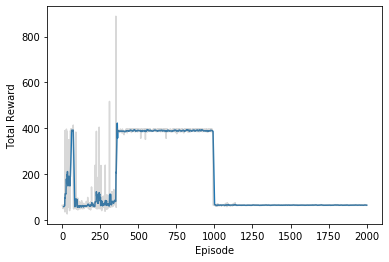

[57.96855724 58.25389989 58.25415507 ... 64.85596914 64.56845339
 64.85625684]


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Source: https://classroom.udacity.com/nanodegrees/nd009-ent/parts/80594ce0-6c97-4c9b-9158-08e626ee2215/modules/c0d4a29a-d82e-454c-9bb6-c517a652632d/lessons/b2eb26c6-49bb-43fa-9810-45021cc786d5/concepts/d0806599-a169-41ab-ae31-5bcbf848f091
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

eps, rews, duration = np.array(rewards).T
smoothed_rews = running_mean(rews, 10)
smoothed_dur = running_mean(duration, 10)

plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.draw()
plt.show()

print (smoothed_rews[:-10])

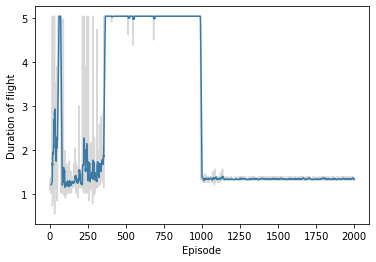

In [3]:
plt.plot(eps[-len(smoothed_dur):], smoothed_dur)
plt.plot(eps, duration, color='grey', alpha=0.3)

plt.xlabel('Episode')
plt.ylabel('Duration of flight')
plt.draw()
plt.show()

### 3D trajectory of the best run

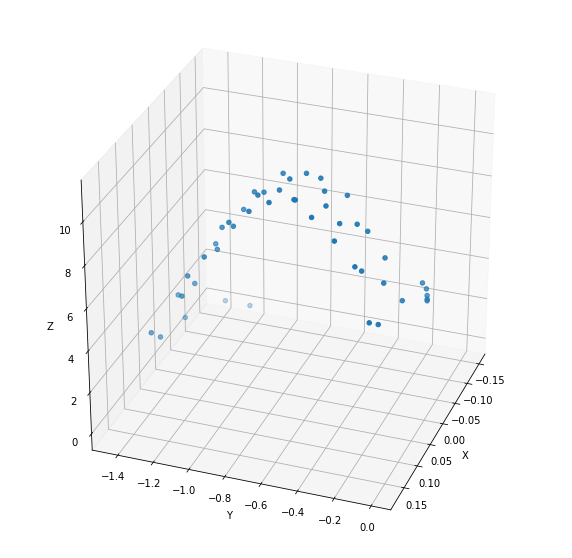

In [4]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt

def plot_trajectory(results):
    fig2 = plt.figure(figsize=(10, 10))
    ax2 = fig2.add_subplot(111, projection='3d')
    ax2.scatter(results['x'], results['y'], results['z'])

    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    ax2.view_init(30, 20)
    plt.draw()
    plt.show()
plot_trajectory(maxresults)

### Detailed metrics of the best run

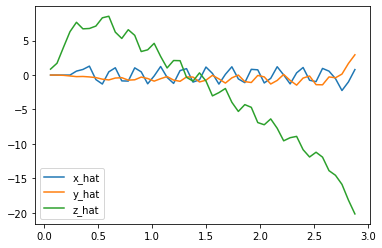

In [5]:
plt.plot(maxresults['time'], maxresults['x_velocity'], label='x_hat')
plt.plot(maxresults['time'], maxresults['y_velocity'], label='y_hat')
plt.plot(maxresults['time'], maxresults['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

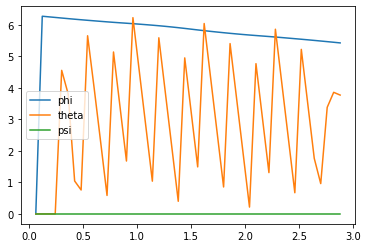

In [6]:
plt.plot(maxresults['time'], maxresults['phi'], label='phi')
plt.plot(maxresults['time'], maxresults['theta'], label='theta')
plt.plot(maxresults['time'], maxresults['psi'], label='psi')
plt.legend()
_ = plt.ylim()

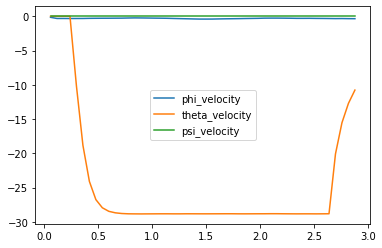

In [7]:
plt.plot(maxresults['time'], maxresults['phi_velocity'], label='phi_velocity')
plt.plot(maxresults['time'], maxresults['theta_velocity'], label='theta_velocity')
plt.plot(maxresults['time'], maxresults['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

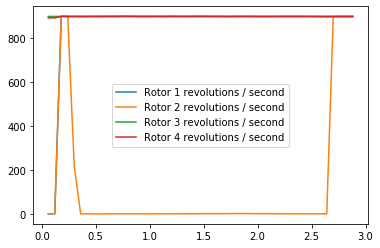

In [8]:
plt.plot(maxresults['time'], maxresults['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(maxresults['time'], maxresults['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(maxresults['time'], maxresults['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(maxresults['time'], maxresults['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

In [9]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[-5.34185418 -0.24912253  0.          0.06487313  2.57497597  0.        ]
[ -4.47416351  -0.97945163 -11.26271449]
[ 16.97915722 -28.840563     0.        ]


## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:
The task of the quadcopter is to take off from the coordinates (0,0,5) and fly to the pose (0,0,10).
The reward function has to reward when the agent flies closer to the target pose and it has to penalize if the agent stays away too far. I am using the L1 norm as part of the reward function; it will reward the agent if it flies closer to the target and penalize it if it stays away. The closer it comes, the more reward it will receive in each step.

The L1 norm has two drawbacks:
- it can become arbitrarily large, which might cause numerical difficulties when I use it in a deep learning setting (vanishing gradients)
- it is only positive, so the agent always gets rewarded, which might lead it to just fly around and not really quickly approach the target pose.

To overcome these drawbacks, the L1 norm is transformed like this `np.tanh(2 - 0.005*(distance))` . This way, the reward is always between -1 and 1, and if the quadcopter is far from the target pose, each move will be penalized. But the reward function always has a nice gradient, so the agent always knows in which direction to move to maximize the reward.

You can find a plot of the reward function here:https://www.wolframalpha.com/input/?i=plot+tanh%282+-+0.005*x%29

Additionally, the agent receives a 10 point reward, if it is especially close to the target pose: `if distance<3: reward=10`. I would like to model a terminal goal state with an exceptionally high reward, so that the agent is motivated to go there and stay there.

I also tried the L2 norm as a distance metric, but it failed to perform nicely. I only saw limited learning progress with the agent. A deeper investigation is needed why the L1 reward function performs so nicely and the L2 reward function is not suitable.

*Lessons learned:*
- critic neural networks with only one layer for states or actions and actor neural networks with only one layer don't seem to capture the complexity too well. I did not see much learning progress for those configurations. Therefore, I ended up reworking the network architecture.


**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:
I tried the two learning algorithms:
- Random Policy Search (linear model)
- DDPG, using the Udacity implementation that came with this project.

The random policy search (linear model) did not perform satisfactorily, as expected. It basically led to the crash of the quadcopter, i.e. the aircraft could not support a sustained flight. Please see workbook Quadcopter_Project_linearmodel.ipynb for details.

DDPG worked pretty well, so I will explain it in further detail in the following paragraphs. The learning algorithm has the following tunable parameters:
- parameters of learning process: no. of episodes, runtime
- parameters of noise process: $\mu$, $\sigma$, $\theta$
- parameters of DDPG agent: $\gamma$, $\tau$
- parameters of replay buffer: batch size, buffer size
- parameters of neural network: learning rate 

- $\mu$, $\sigma$, $\theta$, $\gamma$, $\tau$, batch size, basic_reward, l2 reward, tilt reward, network, qualitative result 

I first used the original network model with original parameters as specified in the Udacity sample code. This did not work so well. After ca. 1000 episodes, the agent was as smart as it would ever be. Most flights lasted shorter than 2 seconds, so the 5 second runtime is more than sufficient. I did some training runs to investigate the best settings; here are my lessons learned:
- most of the time, the agent could not hold the quadcopter in the air; it basically just fell downward like a leaf and was shaking heavily. Not even the rotors were running most of the time. 
- changing the noise process parameters seemed to help with the learning, but it was only a very minor effect, and if the noise became too much, the agent showed erratic behaviour.

In the end, I used the configuration suggested in Lillicrap, Timothy P., et al., 2015. Continuous Control with Deep Reinforcement Learning on page 11 ([Link to PDF file](https://arxiv.org/pdf/1509.02971.pdf)). 

Here is the new network model with optimized parameters:
- parameters of learning process: 
 - no. of episodes: 2000
 - runtime: 5.0
- parameters of noise process: 
 - $\mu=0$ 
 - $\sigma=0.2$
 - $\theta=0.15$
- parameters of DDPG agent: 
 - $\gamma=0.99$
 - $\tau=0.001$
- parameters of replay buffer: 
 - batch size=64
 - buffer size=1000000
- parameters of neural network: 
 - learning rate=0.01 for Adam optimizer. A learning rate of 0.0001 did not yield any visible learning progress. A learning rate of 0.005 yielded a significant improvement, a learning rate of 0.001 delivered a solid baseline, but no stellar results. 

I did some training runs to investigate the best settings; here are my lessons learned:
- agent learns successfully after >1500 episodes: using L1 norm in reward function, no dropout in actor network nor critic network. 
- using the l2 norm reward function, and with dropout in initial layer for actor network, the learning rate is much lower than initially, but still heavy reward peaks.
- using the l2 norm and no dropout in initial layer for actor network, I saw pretty small but steady learning behaviour.
- using learning rate=0.001, no dropout in initial layer for actor network, l1 norm reward function, I saw very good learning behaviour of the agent.
- the agent behaviour (and the learning progress)  is depending on a finely tuned reward function. It has to have the right scale and shape; even small variations lead to visibly worse outcomes.

The neural network architecture looks as follows:
- Actor:
 - layers: 1x input layer, 2x hidden dense layers, output layer
 - sizes: hidden layers with 400,300 units
 - ReLU as activation function for hidden layers
 - Sigmoid activation function for output layer (to encode actions)
 - After each hidden layer, I introduced a BatchNormalization layer.
 - Each hidden layer featured a kernel regularizer to reign in model complexity.
 - no dropout layers were used, as they did not prove helpful.
- Critic: the neural network looks identical to the actor network, except for the actions/states split.

The replay buffer was set at $1*10^6$ elements ( up from $1*10^5$ elements given in the original Udacity source code). This setting is also based on the Lillicrap et al. paper.



**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:
It was a very hard task to learn; the original network configuration with three hidden layers with 32, 64,32 units for the actor was not able to learn it properly, but instead, the task required a much bigger network and more than 1500 training episodes to start learning effectively.

The agent learned continuously from the start, but there was an aha moment at around 350 episodes from which on the agent almost continuously scored maximum points and made very long flights (up to the maximum allowed duration). Obviously, the network learned a good behaviour and settled in a good policy. After epsiode 1000, the total reward caved in, but I assume that it was part of an exploratory phase. During the best run, the quadcopter managed to hover around the target pose (0,0,10).

The final performance was not that stellar, but the episodes before were very good and showed us rewards per episode around 400 points.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:
The hardest part of the project was to find the right neural network architecture and hyperparameters. It turns out that the neural network architecture has the largest impact on the performance of the agent, much more important than the parameters of the DDPG or the noise process and even more important than the reward function. If the neural network is unsuitable, the agent will never learn, even if the reward function is fine. Tuning the reward function is another very hard task because the range of suitable functions is pretty small. If you hit the window, the agent will behave nicely; if you miss it, the agent will show more or less chaotic behaviour and the policy does not converge.

Even if the reward function facilitates agent learning behaviour, it still does not seem to be able to hover at a certain spot, but fly around more or less. Sometimes, I would like to be able to add some rules to the policy which clearly define a certain behaviour in a specific situation (e.g. when in pose xyz and in upright position and close to the target pose, then spin rotors evenly at k RPM)

Even with very similar parameter settings, the quality of the learned policy can vary wildly during and at the end of the training episodes. Even though the agent can exhibit very good behaviour during the training episodes, it is not guaranteed that it will end up with the best policy after the last training episode.

I found a peculiar situation: the agent tries negative rotor speeds, as the noise process can yield negative numbers. The trained actor network only outputs rotor speeds >=0, but adding noise to it makes it negative which is a physical impossibility. The physics sim covers this edge case correctly, but it would have been good to point it out in the description.

One major improvement might be the usage of a more deterministic learning approach. Right now, we have a lot of parameters, a noise function and several complex neural networks which implement the learning algorithm. This system is powerful, but hard to understand and debug. Improvements are achieved by trial-and-error and not by careful engineering. So I would suggest to build a simpler model and study its learning progress. This might yield a better insight into the determinants of a good learning algorithm.
